In [573]:
from __future__ import division, print_function, absolute_import

import tmm
import math
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

from typing import NamedTuple

In [574]:
class Parameters(NamedTuple):
    f_k: int
    n_k: int
    f_m: int
    n_m: int
    k_m: int
    f_a: int
    n_a: int

In [575]:
def cauchy(A, B, wavelength):
    return A + B*wavelength**-2

def melanin_imaginary(wavelength):
    a_m = 0.56
    b_m = 270
    return a_m * math.exp(-wavelength / b_m)

def keratin_index(wavelength):
    A_k = 1.532
    B_k = 5890
    return cauchy(A_k, B_k, wavelength)

def melanin_index(wavelength):
    A_m = 1.648
    B_m = 23700
    return cauchy(A_m, B_m, wavelength)

In [576]:
def calc_melanosome_internal_layer_index(wavelength):
    f_k = 0.05
    n_k = keratin_index(wavelength)
    f_m = 0.4
    n_m = melanin_index(wavelength)
    k_m = melanin_imaginary(wavelength)
    f_a = 0.55
    n_a = 1
    return Parameters(f_k, n_k, f_m, n_m, k_m, f_a, n_a)

In [577]:
def calc_keratin_layer(wavelength):
    f_k = 1
    n_k = keratin_index(wavelength)
    f_m = 0
    n_m = 0
    k_m = 0
    f_a = 0
    n_a = 0
    return Parameters(f_k, n_k, f_m, n_m, k_m, f_a, n_a)

In [578]:
def calc_melanin_layer(wavelength):
    f_k = 0
    n_k = 0
    f_m = 1
    n_m = melanin_index(wavelength)
    k_m = melanin_imaginary(wavelength)
    f_a = 0
    n_a = 0
    return Parameters(f_k, n_k, f_m, n_m, k_m, f_a, n_a)

In [579]:
def calc_refractive_index(params: Parameters):
    n_eff = (params.f_k*params.n_k
            + params.f_m*(params.n_m - complex(params.k_m))
            + params.f_a*params.n_a)

    return n_eff

In [580]:
def calc_layers(wavelength):
    # Thicknesses in nm
    keratin_cortex_thickness = 5
    keratin_separation_thickness = 50
    melanosome_membrane_thickness = 30
    # Note: this can be changed to adjust periodicity
    melanosome_internal_thickness = 100
    top_melanosome_internal_thickness = 50

    keratin_layer_index = calc_refractive_index(calc_keratin_layer(wavelength))
    melanosome_membrane_index = calc_refractive_index(calc_melanin_layer(wavelength))
    melanosome_internal_index = calc_refractive_index(calc_melanosome_internal_layer_index(wavelength))

    # Init layers to first infinite air layer
    layers = [[np.inf, 1]]

    # Add keratin cortex layer
    layers.append([keratin_cortex_thickness, keratin_layer_index])

    # Add top melanosome layer
    layers.append([melanosome_membrane_thickness, melanosome_membrane_index])
    layers.append([top_melanosome_internal_thickness, melanosome_internal_index])
    layers.append([melanosome_membrane_thickness, melanosome_membrane_index])

    # Add the rest of the keratin separation and melanosome layers
    melanosome_layers = 12
    melanosome_layers -= 1 # Because of the top melanosome layer
    for _ in range(melanosome_layers):
        layers.append([keratin_separation_thickness, keratin_layer_index])
        layers.append([melanosome_membrane_thickness, melanosome_membrane_index])
        layers.append([melanosome_internal_thickness, melanosome_internal_index])
        layers.append([melanosome_membrane_thickness, melanosome_membrane_index])

    # Add keratin cortex layer
    layers.append([keratin_cortex_thickness, keratin_layer_index])

    # Add last infinite air layer
    layers.append([np.inf, 1])

    return layers

Text(0.5, 1.0, 'Reflectance at normal incidence')

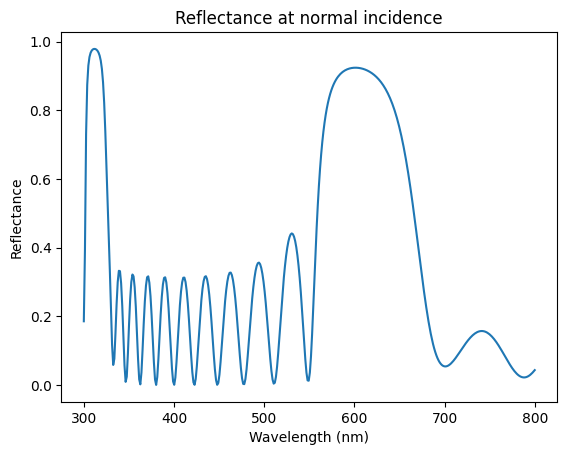

In [581]:
lambda_list = np.linspace(300,800,400) # in nm
T_list = []
for wavelength in lambda_list:
    layers = np.array(calc_layers(wavelength))
    T_list.append(tmm.coh_tmm('s', layers[:, 1], layers[:, 0].real, math.radians(0), wavelength)['R'])
plt.figure()
plt.plot(lambda_list,T_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Reflectance at normal incidence')